In [1]:
import fastai.basics as fai
import fastai.vision as fv
import torch
import torch.nn as nn
from pathlib import Path

In [3]:
def num_params(model):
    total=0
    for p in list(model.parameters()):
        num=1
        for s in list(p.size()):
            num *= s
        total += num
    return total

In [4]:
def conv_block(ni, no, k=3, s=1, pad="same", bn = True, activation = True, g = 1):
    if pad == "same": 
        pad = k//2
    
    layers = []
    
    if bn:
        layers += [nn.BatchNorm2d(ni)]
       
    if activation:
        layers += [nn.ReLU(inplace=True)]
    
    layers += [nn.Conv2d(ni, no, kernel_size=k, stride=s, padding=pad, bias = not bn, groups=g)]
    
    return nn.Sequential(*layers)

In [5]:
class ResBlock(nn.Module):
    def __init__(self, nf, mid=None):
        super().__init__()
        
        if mid == None:
            mid = nf
        
        BN = nn.BatchNorm2d(nf)
        with torch.no_grad():
            for p in BN.parameters():
                p.zero_()
        
        self.residual = nn.Sequential(conv_block(nf,mid,activation=False), 
                                      conv_block(mid,nf,bn=False),
                                      BN)
        
    def forward(self, x):
        return x + self.residual(x)

In [6]:
def learnable_avg_pool(ni, g = None):
    if g == None:
        g = ni
    ap = nn.Conv2d(ni,ni,kernel_size=2,stride=2,groups=g,bias=False)
    with torch.no_grad():
        for p in ap.parameters():
            p.zero_()
            p += 0.25
    return ap

In [7]:
class Downscale(nn.Module):
    def __init__(self, ni, no, g = None):
        super().__init__()
        self.mp = nn.MaxPool2d(2)
        self.ap = learnable_avg_pool(ni, g)
        self.conv = conv_block(2*ni,no,k=1,s=1,pad=0)
    
    def forward(self, x):
        m = self.mp(x)
        a = self.ap(x)
        y = torch.cat((m,a),dim=1)
        return self.conv(y)

In [11]:
def create_model(fout):
    return nn.Sequential(
                    conv_block(3,64,k=7,s=2,activation=False),
                    ResBlock(64),
                    nn.ReLU(),
                    ResBlock(64),
                    Downscale(64,128),
                    ResBlock(128),
                    Downscale(128,128),
                    ResBlock(128),
                    Downscale(128,256),
                    ResBlock(256),
                    nn.ReLU(),
                    ResBlock(256),
                    Downscale(256,512),
                    ResBlock(512),
                    nn.Tanh(),
                    fai.AdaptiveConcatPool2d(),
                    fai.Flatten(),
                    nn.Linear(1024,fout)
            )

In [12]:
path = Path("imagenette/")

In [13]:
def load_data(folder, img_size, batch_size):
    tfms = fv.get_transforms(flip_vert=False, max_rotate=10, max_lighting=0.3,max_zoom=1.2) #tfms = transforms
    data = (fv.ImageList
            .from_folder(folder)
            .split_by_folder()
            .label_from_folder()
            .transform(tfms,size=img_size)
            .databunch(bs=batch_size))
    return data

In [14]:
data = load_data(path, img_size=256, batch_size=128)

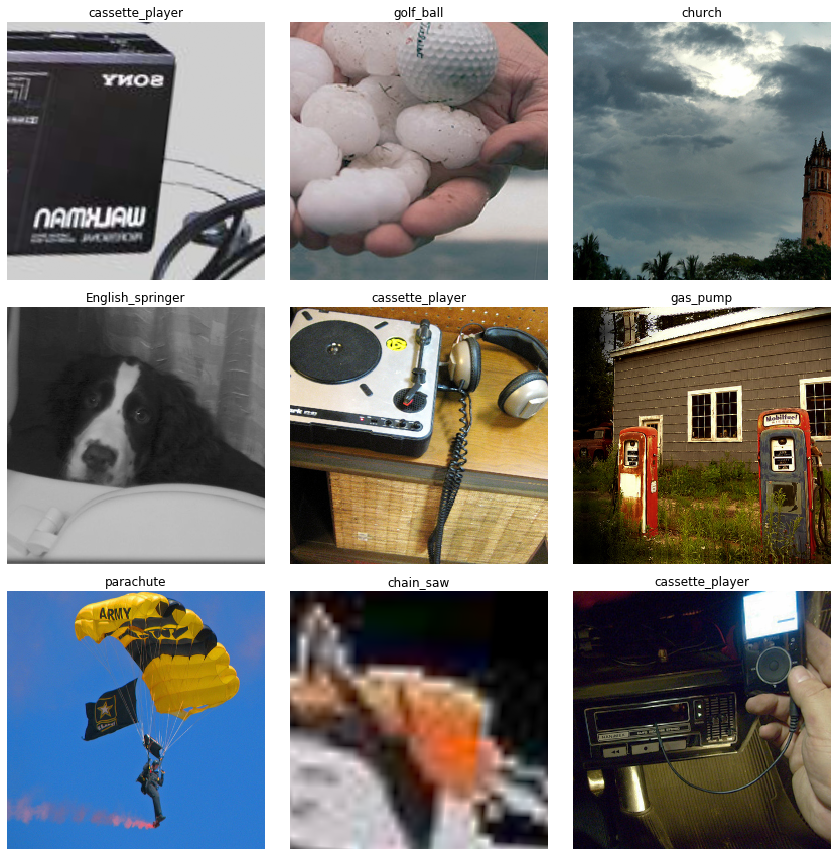

In [15]:
data.show_batch(rows=3)

In [16]:
data.c

10

In [17]:
model = create_model(data.c)

In [18]:
model

Sequential(
  (0): Sequential(
    (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  )
  (1): ResBlock(
    (residual): Sequential(
      (0): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): Sequential(
        (0): ReLU(inplace=True)
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (2): ReLU()
  (3): ResBlock(
    (residual): Sequential(
      (0): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): Seq

In [19]:
num_params(model)

8223312

In [20]:
learn=fv.Learner(data,model,wd=0.1,metrics=fv.accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


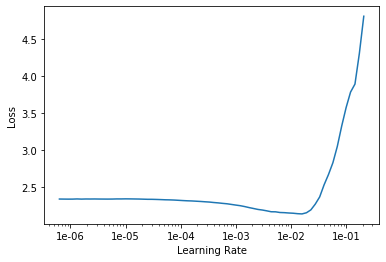

In [21]:
learn.lr_find(); learn.recorder.plot()

In [22]:
learn.fit_one_cycle(2,4e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.452815,1.301111,0.580000,00:55
1,0.987824,0.733434,0.778000,00:55


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


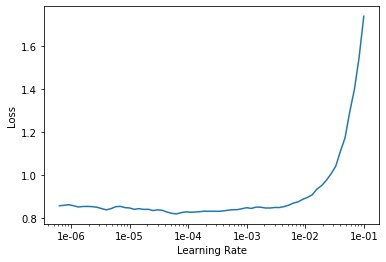

In [23]:
learn.lr_find(); learn.recorder.plot()

In [24]:
learn.fit_one_cycle(3,4e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.809485,0.694289,0.784000,00:56
1,0.748328,0.600560,0.818000,00:56
2,0.681465,0.568348,0.844000,00:56
